<a href="https://colab.research.google.com/github/nickystark/TerroristDetection/blob/main/TerroristDetectionAugmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
!pip install -q pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 59.8 MB/s eta 0:00:00


In [2]:
import os
import torch
import torchmetrics
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

#Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
output_folder = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/augmented_images-Ter'  # Replace with your desired folder path
if not os.path.exists(output_folder):
  os.makedirs(output_folder, exist_ok=True)

In [5]:
output_folder_val = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/valid/augmented_images-Ter'  # Replace with your desired folder path
if not os.path.exists(output_folder_val):
  os.makedirs(output_folder_val, exist_ok=True)

# **Path Images**

In [6]:
#train path
main_path = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection'
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
valid_dir = os.path.join(main_path, 'valid')

#valid path
valid_dir = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/valid'
valid_ter = os.path.join(valid_dir, 'Terrorist')
valid_no_ter = os.path.join(valid_dir, 'NoTerrorist')
valid_ter_mult = os.path.join(valid_dir, 'Terrorist_multiple')
valid_no_ter_mult = os.path.join(valid_dir, 'NoTerrorist_multiple')

#test path
test_dir = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/test'
test_ter = os.path.join(test_dir, 'Terrorist')
test_no_ter = os.path.join(test_dir, 'NoTerrorist')
test_ter_mult = os.path.join(test_dir, 'Terrorist_multiple')
test_no_ter_mult = os.path.join(test_dir, 'NoTerrorist_multiple')

#Train

In [7]:
#Terrorist Folders
train_ter = os.path.join(train_dir, 'Terrorist')
train_ter_mult = os.path.join(train_dir, 'Terrorist_multiple')
#Not Terrorist Folders
train_no_ter = os.path.join(train_dir, 'NoTerrorist')
#train_no_ter1 = os.path.join(train_dir, 'NoTerrorist Terrorist')
#train_no_ter_mult = os.path.join(train_dir, 'NoTerrorist Terrorist_multiple')
train_no_ter_mult1 = os.path.join(train_dir, 'NoTerrorist_multiple')
#train_no_ter_mult2 = os.path.join(train_dir, 'NoTerrorist_multiple Terrorist')
#train_no_ter_mult3 = os.path.join(train_dir, 'NoTerrorist_multiple Terrorist_multiple')

# Dataframe

In [8]:
train_data = []
train_labels = []

valid_data = []
valid_labels = []

test_data = []
test_labels = []

def create_dataframe(path, data, labels):
  last_word = path.split('/')[-1]

  if 'No' in last_word:
    label = 0 #not terrorist
  else:
    label = 1 #terrorist

  for filepath in os.listdir(path):
    completeFilePath = os.path.join(path, filepath)
    data.append(completeFilePath)
    labels.append(label)

#create_dataframe TRAIN
create_dataframe(train_no_ter, train_data, train_labels)
create_dataframe(train_ter, train_data, train_labels)
#create_dataframe(train_no_ter1, train_data, train_labels)
#create_dataframe(train_no_ter_mult, train_data, train_labels)
create_dataframe(train_no_ter_mult1, train_data, train_labels)
#create_dataframe(train_no_ter_mult2, train_data, train_labels)
#create_dataframe(train_no_ter_mult3, train_data, train_labels)
create_dataframe(train_ter_mult, train_data, train_labels)
#create_dataframe VALID
create_dataframe(valid_no_ter, valid_data, valid_labels)
create_dataframe(valid_ter, valid_data, valid_labels)
create_dataframe(valid_ter_mult, valid_data, valid_labels)
create_dataframe(valid_no_ter_mult, valid_data, valid_labels)
#create_dataframe TEST
create_dataframe(test_no_ter, test_data, test_labels)
create_dataframe(test_ter, test_data, test_labels)
create_dataframe(test_no_ter_mult, test_data, test_labels)
create_dataframe(test_ter_mult, test_data, test_labels)


In [9]:
#Create Train Dataframe (namepath, label)
train_df = pd.DataFrame({'filename': train_data, 'label': train_labels})
#train_df

Augmented images

In [10]:
#Tranformations for augmented images
tr_augmented1 = transforms.Compose([
  transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally
  transforms.RandomRotation(20),    # Randomly rotates the image up to 20 degrees
  transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # Randomly crops the image
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2), # Randomly adjusts the color
])

tr_augmented2 = transforms.Compose([
  transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally
  transforms.RandomRotation(51),    # Randomly rotates the image up to 20 degrees
  transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # Randomly crops the image
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2), # Randomly adjusts the color
  transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
])

# Create a separate list to store augmented image data
augmented_data = []

for round in range(3):
  for index, row in train_df.iterrows():
      # Check if the image should be augmented (e.g., if label is of a specific class)
      if row['label'] == 1:
        imagepath = row['filename']
        if os.path.exists(imagepath):
          image = Image.open(imagepath).convert('RGB')
          image_augmented1 = tr_augmented1(image)
          image_augmented2 = tr_augmented2(image)
          # Generate a unique filename for the augmented image
          filename1 = f"augmented1_{index}_{round}.jpg"  # name of the file
          filename2 = f"augmented2_{index}_{round}.jpg"  # name of the file

          # Save the augmented image to the output folder
          image_augmented1.save(os.path.join(output_folder, filename1))
          image_augmented2.save(os.path.join(output_folder, filename2))

          # Append the augmented data to the list
          filepath1 = (output_folder, filename1)
          augmented_data.append({'filename': "/".join(filepath1), 'label': row['label']})
          filepath2 = (output_folder, filename2)
          augmented_data.append({'filename': "/".join(filepath2), 'label': row['label']})

# Add the augmented data to the DataFrame outside the loop
train_df = pd.concat([train_df, pd.DataFrame(augmented_data)], ignore_index=True)
#train_df

In [11]:

#valid_dataframe
valid_df = pd.DataFrame({'filename': valid_data, 'label': valid_labels})
valid_df

,filename,label
0,/content/drive/MyDrive/TerroristDetection/Terr...,0
1,/content/drive/MyDrive/TerroristDetection/Terr...,0
2,/content/drive/MyDrive/TerroristDetection/Terr...,0
3,/content/drive/MyDrive/TerroristDetection/Terr...,0
4,/content/drive/MyDrive/TerroristDetection/Terr...,0
...,...,...
270,/content/drive/MyDrive/TerroristDetection/Terr...,0
271,/content/drive/MyDrive/TerroristDetection/Terr...,0
272,/content/drive/MyDrive/TerroristDetection/Terr...,0
273,/content/drive/MyDrive/TerroristDetection/Terr...,0


In [12]:
#Tranformations for augmented images
tr_augmented = transforms.Compose([
  transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally
  transforms.RandomRotation(20),    # Randomly rotates the image up to 20 degrees
  transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # Randomly crops the image
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2), # Randomly adjusts the color
])

# Create a separate list to store augmented image data
augmented_data_val = []

for index, row in valid_df.iterrows():
      # Check if the image should be augmented (e.g., if label is of a specific class)
      if row['label'] == 1:
        imagepath = row['filename']
        if os.path.exists(imagepath):
          image = Image.open(imagepath).convert('RGB')
          image_augmented = tr_augmented1(image)
          # Generate a unique filename for the augmented image
          filename = f"augmented1_{index}.jpg"  # name of the file

          # Save the augmented image to the output folder
          image_augmented.save(os.path.join(output_folder_val, filename))

          # Append the augmented data to the list
          filepath = (output_folder_val, filename)
          augmented_data_val.append({'filename': "/".join(filepath), 'label': row['label']})

# Add the augmented data to the DataFrame outside the loop
valid_df = pd.concat([valid_df, pd.DataFrame(augmented_data_val)], ignore_index=True)
#train_df

In [13]:
#test_data
test_df = pd.DataFrame({'filename': test_data, 'label': test_labels})
test_df

,filename,label
0,/content/drive/MyDrive/TerroristDetection/Terr...,0
1,/content/drive/MyDrive/TerroristDetection/Terr...,0
2,/content/drive/MyDrive/TerroristDetection/Terr...,0
3,/content/drive/MyDrive/TerroristDetection/Terr...,0
4,/content/drive/MyDrive/TerroristDetection/Terr...,0
...,...,...
137,/content/drive/MyDrive/TerroristDetection/Terr...,1
138,/content/drive/MyDrive/TerroristDetection/Terr...,1
139,/content/drive/MyDrive/TerroristDetection/Terr...,1
140,/content/drive/MyDrive/TerroristDetection/Terr...,1


In [14]:
#random.shuffle(train_df)
# Mischia il DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

<Axes: title={'center': 'label'}, ylabel='Frequency'>

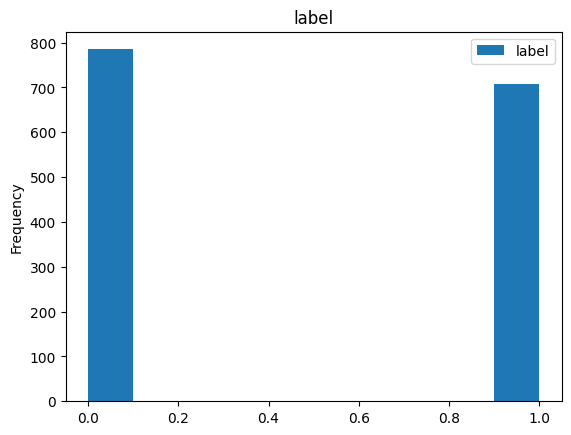

In [15]:
train_df.plot(kind='hist', title = 'label')


Valid Plot

<Axes: title={'center': 'label'}, ylabel='Frequency'>

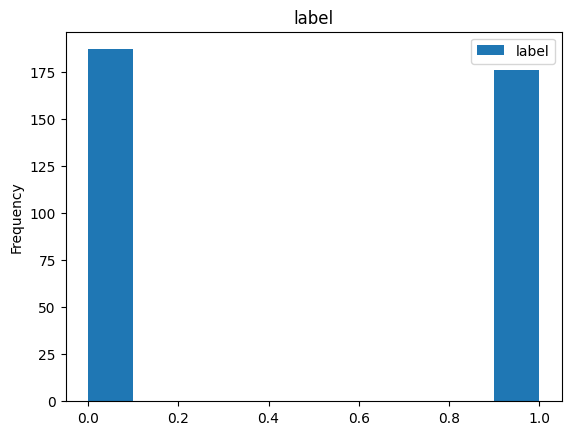

In [16]:
valid_df.plot(kind='hist', title = 'label')

Test Plot

<Axes: title={'center': 'label'}, ylabel='Frequency'>

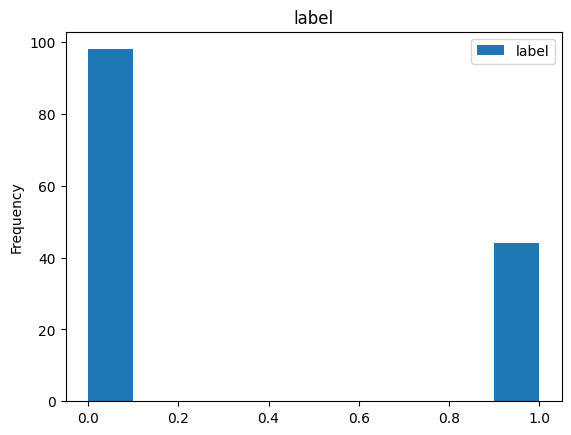

In [17]:
test_df.plot(kind='hist', title = 'label')


# Dataset

In [18]:
class terrorismDetectionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data = []
        for index, row in df.iterrows():
          imagepath = row['filename']
          label = row['label']
          image = Image.open(imagepath).convert('RGB')
          tr = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
        ])
          imageTransorfm = tr(image)
          item = {'input': imageTransorfm, 'label': label, 'realImage' : image}
          self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = self.data[idx]['input']
        label = self.data[idx]['label']
        imagepath = self.df.iloc[idx]['filename'] # Get imagepath from the DataFrame
        image = Image.open(imagepath).convert('RGB')
        tr = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        imageTransorfm = tr(image)
        item = {'input': input, 'label': label, 'realImage' : image}
        return item

In [19]:
train_dataset = terrorismDetectionDataset(train_df)


In [20]:
train_dataset.__len__()

1492

In [21]:
train_dataset.__getitem__(10).get('input').size()

torch.Size([3, 224, 224])

In [22]:
train_dataset.__getitem__(10).get('input')


tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1137, 0.1255, 0.1255],
         [0.1098, 0.1098, 0.1098,  ..., 0.1137, 0.1255, 0.1255],
         [0.1098, 0.1098, 0.1098,  ..., 0.1137, 0.1255, 0.1255],
         ...,
         [0.4588, 0.2667, 0.2314,  ..., 0.1098, 0.1098, 0.1098],
         [0.4784, 0.2745, 0.2235,  ..., 0.1098, 0.1098, 0.1098],
         [0.4549, 0.2745, 0.2471,  ..., 0.1098, 0.1098, 0.1098]],

        [[0.1176, 0.1176, 0.1176,  ..., 0.1098, 0.1020, 0.1020],
         [0.1137, 0.1137, 0.1137,  ..., 0.1098, 0.1020, 0.1020],
         [0.1098, 0.1098, 0.1098,  ..., 0.1098, 0.1020, 0.1020],
         ...,
         [0.4863, 0.2941, 0.2588,  ..., 0.1098, 0.1098, 0.1098],
         [0.5098, 0.3059, 0.2510,  ..., 0.1098, 0.1098, 0.1098],
         [0.4863, 0.3059, 0.2745,  ..., 0.1098, 0.1098, 0.1098]],

        [[0.0745, 0.0745, 0.0745,  ..., 0.0941, 0.1020, 0.1098],
         [0.0902, 0.0902, 0.0902,  ..., 0.0941, 0.1020, 0.1098],
         [0.1176, 0.1176, 0.1098,  ..., 0.0941, 0.1020, 0.

In [23]:
#real_image = train_dataset.__getitem__(10).get('realImage')
#real_image

#Data Module

In [24]:
class terrorismDetectionDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_df,
                 valid_df,
                 test_df,
                 batch_size : int = 2,
    ):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = terrorismDetectionDataset(self.train_df)
            self.valid_dataset = terrorismDetectionDataset(self.valid_df)
        if stage == 'test':
            self.test_dataset = terrorismDetectionDataset(self.test_df)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, collate_fn=self.prepare_batch)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, collate_fn=self.prepare_batch)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, collate_fn=self.prepare_batch)

    def prepare_batch(self, batch):
      prepared_batch = {}
      inputs = [item['input'] for item in batch]
      labels = [item['label'] for item in batch]
      prepared_batch['input'] = torch.stack(inputs)
      prepared_batch['label'] = torch.tensor(labels)
      return prepared_batch

In [25]:
prova_dataModule = terrorismDetectionDataModule(train_df, valid_df, test_df)

#Device

In [26]:
! nvidia-smi
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Tue Jan 21 20:13:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

#Model

In [27]:
class myModel(pl.LightningModule):
    def __init__(self):
        super(myModel, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=1)
        self.convolution2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1)
        self.convolution4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(in_features=32 * 53 * 53, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
        self.accuracy = torchmetrics.Accuracy(task="binary")
        self.loss = nn.BCELoss()
        self.train_loss = []
        self.val_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.test_accuracy = []
        self.train_loss_for_plot = []
        self.val_loss_for_plot = []
        self.test_loss_for_plot = []
        self.train_accuracy_for_plot = []
        self.val_accuracy_for_plot = []
        self.test_accuracy_for_plot = []

    def forward(self, x):
        x = self.convolution1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.convolution2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        loss = self.loss(outputs, labels.unsqueeze(1).float())
        accuracy = self.accuracy(outputs, labels.unsqueeze(1).float())

        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy)
        self.train_loss.append(loss.item())
        self.train_accuracy.append(accuracy.item())
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        loss = self.loss(outputs, labels.unsqueeze(1).float())
        accuracy = self.accuracy(outputs, labels.unsqueeze(1).float())

        self.log('val_loss', loss)
        self.log('val_accuracy', accuracy)
        self.val_loss.append(loss.item())
        self.val_accuracy.append(accuracy.item())
        return loss

    def test_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        loss = self.loss(outputs, labels.unsqueeze(1).float())
        accuracy = self.accuracy(outputs, labels.unsqueeze(1).float())

        self.log('test_loss', loss)
        self.log('test_accuracy', accuracy)
        return loss

    def on_train_epoch_end(self):
        avg_train_loss = sum(self.train_loss) / len(self.train_loss) if self.train_loss else 0
        avg_train_accuracy = sum(self.train_accuracy) / len(self.train_accuracy) if self.train_accuracy else 0
        print(f'Epoch {self.current_epoch} Train\n'
                f'- Train Loss: {avg_train_loss:.4f}'
                f'- Train Accuracy: {avg_train_accuracy:.4f}'
                )
        self.train_loss_for_plot.append(avg_train_loss)
        self.train_loss = []
        self.train_accuracy_for_plot.append(avg_train_accuracy)
        self.train_accuracy = []

    def on_validation_epoch_end(self):
        avg_val_loss = sum(self.val_loss) / len(self.val_loss) if self.val_loss else 0
        avg_val_accuracy = sum(self.val_accuracy) / len(self.val_accuracy) if self.val_accuracy else 0
        print(f'Epoch {self.current_epoch} Validation\n'
                f'- Validation Loss: {avg_val_loss:.4f}'
                f'- Validation Accuracy: {avg_val_accuracy:.4f}'
                )
        self.val_loss_for_plot.append(avg_val_loss)
        self.val_loss = []
        self.val_accuracy_for_plot.append(avg_val_accuracy)
        self.val_accuracy = []

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=0.001)
        return optimizer
    def getLists(self):
        return self.train_loss_for_plot, self.val_loss_for_plot, self.train_accuracy_for_plot, self.val_accuracy_for_plot

#Setup

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
trainer = pl.Trainer(max_epochs = 50)#, callbacks=[early_stopping])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [29]:
myDataModule = terrorismDetectionDataModule(train_df, valid_df, test_df)
my_model = myModel()

In [30]:
trainer.fit(my_model, myDataModule)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name         | Type           | Params | Mode 
---------------------------------------------------------
0  | convolution1 | Conv2d         | 1.2 K  | train
1  | convolution2 | Conv2d         | 12.8 K | train
2  | convolution3 | Conv2d         | 51.3 K | train
3  | convolution4 | Conv2d         | 51.2 K | train
4  | relu1        | ReLU           | 0      | train
5  | maxpool1     | MaxPool2d      | 0      | train
6  | relu2        | ReLU           | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0 Validation
- Validation Loss: 0.6970- Validation Accuracy: 0.5000


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation
- Validation Loss: 47.9890- Validation Accuracy: 0.5166
Epoch 0 Train
- Train Loss: 24.6104- Train Accuracy: 0.5255


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation
- Validation Loss: 43.2345- Validation Accuracy: 0.5166
Epoch 1 Train
- Train Loss: 23.3349- Train Accuracy: 0.5261


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Validation
- Validation Loss: 14.9086- Validation Accuracy: 0.5166
Epoch 2 Train
- Train Loss: 23.2632- Train Accuracy: 0.5261


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Validation
- Validation Loss: 0.6944- Validation Accuracy: 0.5442
Epoch 3 Train
- Train Loss: 2.2384- Train Accuracy: 0.5469


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Validation
- Validation Loss: 0.7876- Validation Accuracy: 0.5359
Epoch 4 Train
- Train Loss: 0.6376- Train Accuracy: 0.6334


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Validation
- Validation Loss: 0.7119- Validation Accuracy: 0.5497
Epoch 5 Train
- Train Loss: 0.6127- Train Accuracy: 0.6280


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Validation
- Validation Loss: 0.7365- Validation Accuracy: 0.5829
Epoch 6 Train
- Train Loss: 0.6033- Train Accuracy: 0.6408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Validation
- Validation Loss: 0.7068- Validation Accuracy: 0.5801
Epoch 7 Train
- Train Loss: 0.5994- Train Accuracy: 0.6468


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Validation
- Validation Loss: 0.7540- Validation Accuracy: 0.5912
Epoch 8 Train
- Train Loss: 0.5998- Train Accuracy: 0.6421


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Validation
- Validation Loss: 0.7129- Validation Accuracy: 0.6105
Epoch 9 Train
- Train Loss: 0.5955- Train Accuracy: 0.6508


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Validation
- Validation Loss: 0.7290- Validation Accuracy: 0.6050
Epoch 10 Train
- Train Loss: 0.5744- Train Accuracy: 0.6609


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Validation
- Validation Loss: 0.8017- Validation Accuracy: 0.6188
Epoch 11 Train
- Train Loss: 0.5686- Train Accuracy: 0.6669


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Validation
- Validation Loss: 0.6988- Validation Accuracy: 0.6188
Epoch 12 Train
- Train Loss: 0.5627- Train Accuracy: 0.6716


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Validation
- Validation Loss: 0.6909- Validation Accuracy: 0.6243
Epoch 13 Train
- Train Loss: 0.5551- Train Accuracy: 0.6702


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Validation
- Validation Loss: 0.7332- Validation Accuracy: 0.6381
Epoch 14 Train
- Train Loss: 0.5541- Train Accuracy: 0.6736


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Validation
- Validation Loss: 0.7157- Validation Accuracy: 0.6298
Epoch 15 Train
- Train Loss: 0.5265- Train Accuracy: 0.6830


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Validation
- Validation Loss: 0.6851- Validation Accuracy: 0.6022
Epoch 16 Train
- Train Loss: 0.5353- Train Accuracy: 0.6897


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 Validation
- Validation Loss: 0.6868- Validation Accuracy: 0.6105
Epoch 17 Train
- Train Loss: 0.5172- Train Accuracy: 0.6836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 Validation
- Validation Loss: 0.7046- Validation Accuracy: 0.6215
Epoch 18 Train
- Train Loss: 0.5357- Train Accuracy: 0.6723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 Validation
- Validation Loss: 0.7551- Validation Accuracy: 0.5994
Epoch 19 Train
- Train Loss: 0.5180- Train Accuracy: 0.6897


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 Validation
- Validation Loss: 0.6667- Validation Accuracy: 0.6271
Epoch 20 Train
- Train Loss: 0.5207- Train Accuracy: 0.6783


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 Validation
- Validation Loss: 0.6962- Validation Accuracy: 0.6271
Epoch 21 Train
- Train Loss: 0.5111- Train Accuracy: 0.6843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 Validation
- Validation Loss: 0.7120- Validation Accuracy: 0.6298
Epoch 22 Train
- Train Loss: 0.5064- Train Accuracy: 0.6870


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 Validation
- Validation Loss: 0.7318- Validation Accuracy: 0.6188
Epoch 23 Train
- Train Loss: 0.4972- Train Accuracy: 0.6944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 Validation
- Validation Loss: 0.7131- Validation Accuracy: 0.6271
Epoch 24 Train
- Train Loss: 0.4944- Train Accuracy: 0.6977


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 Validation
- Validation Loss: 0.8472- Validation Accuracy: 0.6050
Epoch 25 Train
- Train Loss: 0.5155- Train Accuracy: 0.6944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 Validation
- Validation Loss: 0.8208- Validation Accuracy: 0.5691
Epoch 26 Train
- Train Loss: 0.4804- Train Accuracy: 0.7192


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 Validation
- Validation Loss: 0.7237- Validation Accuracy: 0.6215
Epoch 27 Train
- Train Loss: 0.4924- Train Accuracy: 0.6903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 Validation
- Validation Loss: 0.7522- Validation Accuracy: 0.6243
Epoch 28 Train
- Train Loss: 0.4923- Train Accuracy: 0.6890


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 Validation
- Validation Loss: 0.8289- Validation Accuracy: 0.6160
Epoch 29 Train
- Train Loss: 0.4557- Train Accuracy: 0.7252


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 Validation
- Validation Loss: 0.7499- Validation Accuracy: 0.6326
Epoch 30 Train
- Train Loss: 0.4629- Train Accuracy: 0.7145


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 Validation
- Validation Loss: 0.8059- Validation Accuracy: 0.6326
Epoch 31 Train
- Train Loss: 0.4652- Train Accuracy: 0.7225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 Validation
- Validation Loss: 0.8442- Validation Accuracy: 0.6077
Epoch 32 Train
- Train Loss: 0.4775- Train Accuracy: 0.7091


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 Validation
- Validation Loss: 0.7705- Validation Accuracy: 0.6050
Epoch 33 Train
- Train Loss: 0.4469- Train Accuracy: 0.7245


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 Validation
- Validation Loss: 0.8135- Validation Accuracy: 0.6243
Epoch 34 Train
- Train Loss: 0.4418- Train Accuracy: 0.7279


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 Validation
- Validation Loss: 0.7399- Validation Accuracy: 0.6271
Epoch 35 Train
- Train Loss: 0.4627- Train Accuracy: 0.7192


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 Validation
- Validation Loss: 0.8651- Validation Accuracy: 0.6188
Epoch 36 Train
- Train Loss: 0.4501- Train Accuracy: 0.7379


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37 Validation
- Validation Loss: 0.8429- Validation Accuracy: 0.6050
Epoch 37 Train
- Train Loss: 0.4390- Train Accuracy: 0.7339


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38 Validation
- Validation Loss: 0.8707- Validation Accuracy: 0.6215
Epoch 38 Train
- Train Loss: 0.4213- Train Accuracy: 0.7433


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39 Validation
- Validation Loss: 0.7903- Validation Accuracy: 0.5994
Epoch 39 Train
- Train Loss: 0.4620- Train Accuracy: 0.7064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 Validation
- Validation Loss: 1.2453- Validation Accuracy: 0.5331
Epoch 40 Train
- Train Loss: 0.4483- Train Accuracy: 0.7084


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41 Validation
- Validation Loss: 0.7926- Validation Accuracy: 0.6298
Epoch 41 Train
- Train Loss: 0.4607- Train Accuracy: 0.7071


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42 Validation
- Validation Loss: 1.2675- Validation Accuracy: 0.5912
Epoch 42 Train
- Train Loss: 0.4434- Train Accuracy: 0.7239


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43 Validation
- Validation Loss: 0.7734- Validation Accuracy: 0.6271
Epoch 43 Train
- Train Loss: 0.4689- Train Accuracy: 0.7218


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44 Validation
- Validation Loss: 0.8934- Validation Accuracy: 0.6133
Epoch 44 Train
- Train Loss: 0.4371- Train Accuracy: 0.7259


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 Validation
- Validation Loss: 1.0696- Validation Accuracy: 0.6105
Epoch 45 Train
- Train Loss: 0.4374- Train Accuracy: 0.7192


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46 Validation
- Validation Loss: 1.1225- Validation Accuracy: 0.6133
Epoch 46 Train
- Train Loss: 0.4362- Train Accuracy: 0.7332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47 Validation
- Validation Loss: 0.8905- Validation Accuracy: 0.6298
Epoch 47 Train
- Train Loss: 0.4458- Train Accuracy: 0.7205


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48 Validation
- Validation Loss: 1.1186- Validation Accuracy: 0.5994
Epoch 48 Train
- Train Loss: 0.4142- Train Accuracy: 0.7353


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49 Validation
- Validation Loss: 1.0502- Validation Accuracy: 0.6298
Epoch 49 Train
- Train Loss: 0.4453- Train Accuracy: 0.7279


#PLOT METRICS

In [31]:
training_loss, validation_loss, training_accuracy, validation_accuracy = my_model.getLists()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

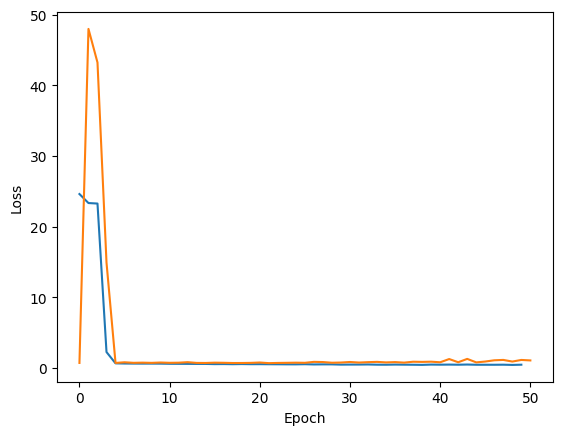

In [32]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

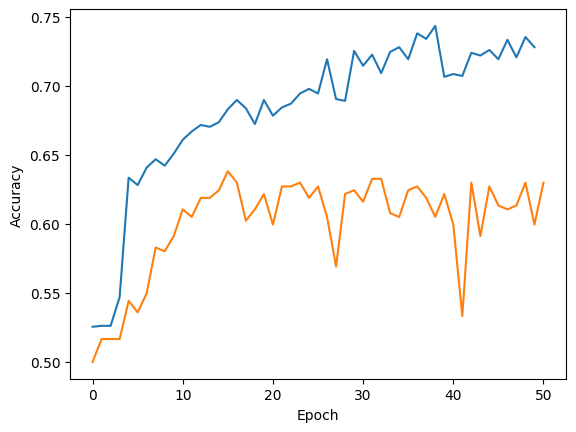

In [33]:
# Plot the training and validation loss
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt

In [37]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(my_model).show() # display using your system viewer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 54.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


AttributeError: 'myModel' object has no attribute 'layers'

In [38]:
!pip install torchinfo
from torchinfo import summary

summary(my_model, input_size=(1, 3, 224, 224)) # Replace (1, 3, 224, 224) with your model's input size

Layer (type:depth-idx)                   Output Shape              Param #
myModel                                  [1, 1]                    102,688
├─Conv2d: 1-1                            [1, 16, 222, 222]         1,216
├─BatchNorm2d: 1-2                       [1, 16, 222, 222]         32
├─ReLU: 1-3                              [1, 16, 222, 222]         --
├─MaxPool2d: 1-4                         [1, 16, 110, 110]         --
├─Conv2d: 1-5                            [1, 32, 108, 108]         12,832
├─BatchNorm2d: 1-6                       [1, 32, 108, 108]         64
├─ReLU: 1-7                              [1, 32, 108, 108]         --
├─MaxPool2d: 1-8                         [1, 32, 53, 53]           --
├─Linear: 1-9                            [1, 1]                    89,889
├─Dropout: 1-10                          [1, 1]                    --
├─Sigmoid: 1-11                          [1, 1]                    --
Total params: 206,721
Trainable params: 206,721
Non-trainable params:

In [40]:
!pip install torchview

In [62]:
from torchview import draw_graph

# Assuming 'my_model' is your PyTorch model and (1, 3, 224, 224) is your input size
input_tensor = torch.randn(1, 3, 224, 224)
model_graph = draw_graph(my_model, input_tensor,  expand_nested=True, save_graph=True)
model_graph.visual_graph.render(filename='model_graph', format='png')

'model_graph.png'